합성곱 신경망을 사용한 이미지 분류

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [3]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

패션 MNIST 데이터 불러오기

In [4]:
#Fashion MNIST 데이터셋을 로드하고 전처리

from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
#뒤에 차원만 하나 추가해서 3차원 -> 4차원 배열로
#0~255까지의 정수값을 255로 나누어주면 0~1 사이의 값으로 스케일링됨 => 신경망 모델의 성능 향상을 위해 필수적

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

합성곱 신경망 만들기

In [5]:
model = keras.Sequential() #Sequential 모델(=Keras에서 가장 간단한 형태의 모델로, 각 레이어를 순차적으로 쌓아 만들 수 있음) 생성

In [6]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1))) #앞에 32는 배치사이즈. 커널(필터)=3은 3*3*1

In [7]:
#Sequential 모델에 Conv2D 레이어를 추가

model.add(keras.layers.MaxPooling2D(2))

#MaxPooling2D 레이어 추가 시 특성 맵의 공간 해상도 감소 => 모델이 위치에 대한 불변성을 학습하고, 더 적은 수의 파라미터로 모델을 구성할 수 있게 됨
#2: 풀링 윈도우의 크기. 여기서는 2x2 크기의 풀링 윈도우 사용

In [8]:
#Sequential 모델에 두 개의 레이어를 추가

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                              padding='same'))
#Conv2D 레이어 추가. 64: 커널(필터)의 개수, 3x3 크기의 필터 사용
#활성화 함수로 ReLU함수(=음수 입력을 0으로 만드는 함수로, 비선형성을 추가하여 모델의 표현력을 향상시킴) 사용
#padding='same' 설정 시 입력과 출력의 크기를 동일하게 유지할 수 있도록 입력에 패딩이 추가됨

model.add(keras.layers.MaxPooling2D(2))
#MaxPooling2D 레이어 추가. 2: 풀링 윈도우의 크기, 2x2 크기의 풀링 윈도우 사용
#입력 이미지를 격자로 나누어 각 격자에서 가장 큰 값을 선택하여 다운샘플링 => 특성맵의 크기를 줄이고, 계산량을 감소시키면서 중요한 정보를 보존

In [9]:
#Sequential 모델에 네 개의 레이어를 추가

model.add(keras.layers.Flatten()) #다차원 -> 1차원 Flatten(=이미지를 일렬로 펼치는 역할) 레이어 추가
model.add(keras.layers.Dense(100, activation='relu')) #Dense 레이어 추가. 100: 뉴런의 개수, 활성화 함수로 ReLU함수 사용
model.add(keras.layers.Dropout(0.4)) #Dropout(=무작위로 일부 뉴런을 제외시킴으로써 과적합을 방지하는 역할) 레이어 추가
model.add(keras.layers.Dense(10, activation='softmax')) #Dense 레이어 추가. 출력 뉴런 10개=클래스의 개수

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

In [19]:
keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
!pip install pydot

In [15]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


모델 컴파일과 훈련

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

#'ModelCheckpoint' 콜백 설정: 모델 훈련 중에 가장 좋은 성능을 보이는 모델을 저장
#save_best_only=True: 최상의 성능을 갖는 모델만 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)

#'EarlyStopping' 콜백 설정: 모델 훈련을 조기 종료시키는 역할
#patience: 성능이 향상되지 않는 에포크를 얼마나 기다릴 것인지를 지정. 2번의 에포크 동안 성능 향상이 없으면 훈련이 조기 종료
#restore_best_weights=True: 훈련이 조기 종료되었을 때 최상의 성능을 갖는 가중치로 모델이 복원
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, #epoch: 전체 훈련 데이터셋을 한 번 훈련하는 것
                    validation_data=(val_scaled, val_target), #검증 데이터(=훈련 과정 중에 모델의 성능을 평가) 지정
                    callbacks=[checkpoint_cb, early_stopping_cb])

#모델 훈련 시 훈련 데이터와 검증 데이터에 대한 손실(loss)과 지정된 메트릭('accuracy')의 값이 기록
#ModelCheckpoint 콜백: 훈련 중 가장 성능이 좋은 모델을 저장, EarlyStopping 콜백: 훈련 과정 중에 성능이 향상되지 않으면 훈련을 조기 종료

Epoch 1/20
1500/1500 [==============================] - 18s 11ms/step - loss: 0.1549 - accuracy: 0.9438 - val_loss: 0.2299 - val_accuracy: 0.9202
Epoch 2/20
  14/1500 [..............................] - ETA: 13s - loss: 0.1169 - accuracy: 0.9665

c:\Users\tjoeun\miniconda3\envs\tensorcpuenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 16s 11ms/step - loss: 0.1399 - accuracy: 0.9489 - val_loss: 0.2309 - val_accuracy: 0.9193
Epoch 3/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1572 - accuracy: 0.9409 - val_loss: 0.2241 - val_accuracy: 0.9210
Epoch 4/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.1390 - accuracy: 0.9463 - val_loss: 0.2293 - val_accuracy: 0.9218
Epoch 5/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1315 - accuracy: 0.9507 - val_loss: 0.2333 - val_accuracy: 0.9222


In [ ]:
import matplotlib.pyplot as plt

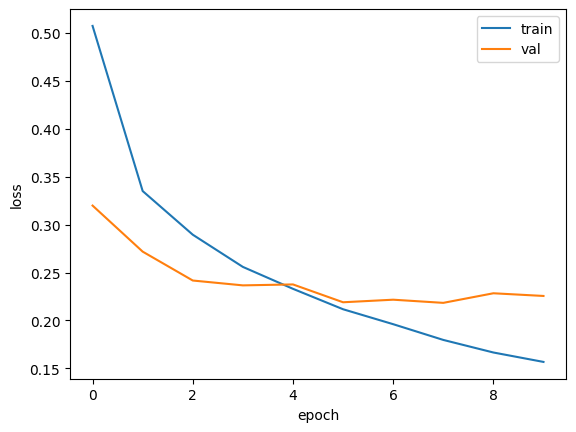

In [ ]:
#훈련 데이터와 검증 데이터에 대한 손실(loss)을 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch') #x축에는 에포크(epoch)
plt.ylabel('loss') #y축에는 손실(loss)
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target) #(검증 데이터의 입력(features), 검증 데이터의 정답(labels))

375/375 [==============================] - 2s 4ms/step - loss: 0.2184 - accuracy: 0.9202


[0.21837268769741058, 0.9201666712760925]

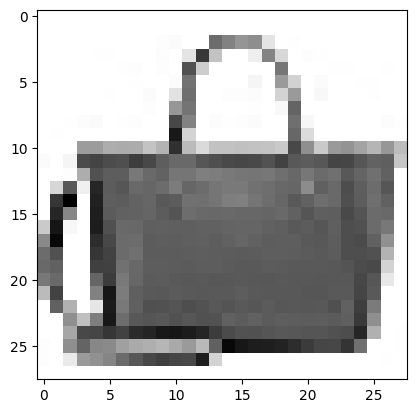

In [ ]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r') #첫 번째 검증 데이터 샘플. 28x28 크기의 1차원 배열 -> 28x28 크기의 이미지로 변환
plt.show()

In [ ]:
preds = model.predict(val_scaled[0:1]) #첫 번째 검증 데이터 샘플에 대한 예측을 수행
print(preds)

1/1 [==============================] - 0s 145ms/step
[[1.8268193e-17 1.3787586e-28 4.2490127e-21 2.5914228e-20 2.0842555e-18
  4.0029022e-16 2.7016874e-17 4.9285534e-18 1.0000000e+00 6.1710207e-19]]


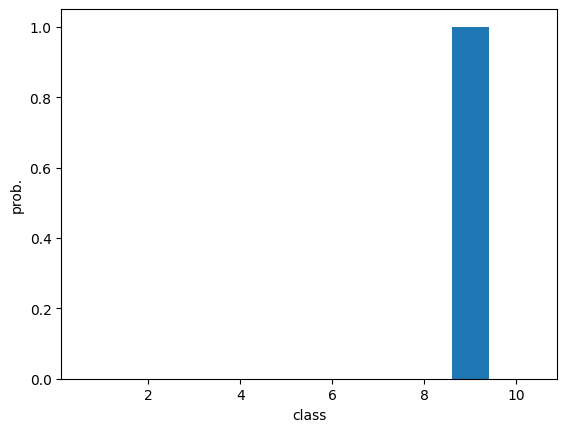

In [ ]:
plt.bar(range(1, 11), preds[0])
#막대 그래프. x축은 클래스, y축은 해당 클래스에 대한 예측 확률
#preds[0]: 모델의 예측 결과. 각 클래스에 대한 예측 확률이 저장된 배열

plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

#각 클래스에 대한 예측 확률을 시각적으로 확인 가능. 가장 높은 막대=해당 클래스에 대한 모델의 예측 확률

In [ ]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
import numpy as np
print(classes[np.argmax(preds)])

#np.argmax(preds): 'preds'배열에서 가장 높은 확률을 갖는 인덱스
#classes[np.argmax(preds)]: 찾은 인덱스를 사용하여 'classes'배열에서 해당 클래스를 가져옴

가방


In [ ]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

#-1: 원래 데이터의 크기를 유지하면서 나머지 차원을 28x28x1 형태로 변경. 1: 흑백 이미지(컬러 이미지의 경우 3(RGB))
#/255.0: 이미지 데이터 정규화

In [ ]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 5ms/step - loss: 0.2438 - accuracy: 0.9153


[0.24375781416893005, 0.9153000116348267]